# Receipt_Count Prediciton Model - Dario Placencio

In [31]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [32]:
# Read the data
df = pd.read_csv('data_daily.csv')

In [33]:
# Convert the data type of Date to datetime
df['# Date'] = pd.to_datetime(df['# Date'])

In [34]:
# Change name of column
df.rename(columns={'# Date': 'Date'}, inplace=True)

In [35]:
# Set Date as index
df.set_index('Date', inplace=True)

In [36]:
# Preview the data
df.head()

,Receipt_Count
Date,
2021-01-01,7564766
2021-01-02,7455524
2021-01-03,7095414
2021-01-04,7666163
2021-01-05,7771289


In [37]:
print(df.index)

DatetimeIndex(['2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04',
               '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
               '2021-01-09', '2021-01-10',
               ...
               '2021-12-22', '2021-12-23', '2021-12-24', '2021-12-25',
               '2021-12-26', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', name='Date', length=365, freq=None)


# Autoregressive Integrated Moving Average (ARIMA)

In [38]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

def expanding_window_arima(train, test_length):
    forecasts = []
    history = list(train)
    test = train[-test_length:]  # Adjust if you have a separate test set

    for i in range(test_length):
        model = ARIMA(history, order=(1,1,1))
        model_fit = model.fit()
        yhat = model_fit.forecast(steps=1)[0]
        forecasts.append(yhat)
        history.append(test.iloc[i])

    return forecasts

# Seasonal Decomposition of Time Series (STL)

STL itself is not a forecasting model. It's a decomposition method. On this case used for the residual component with an ARIMA model for forecasting

In [39]:
from statsmodels.tsa.seasonal import STL

def expanding_window_stl(train, test_length):
    forecasts = []
    history = list(train)
    test = train[-test_length:]

    for i in range(test_length):
        stl = STL(history, seasonal=13, period=7)  # Explicitly setting the period
        result = stl.fit()
        residuals = result.resid
        model = ARIMA(residuals, order=(1,1,1))
        model_fit = model.fit()
        yhat = model_fit.forecast(steps=1)[0]
        forecasts.append(yhat + result.trend[-1] + result.seasonal[-1])
        history.append(test.iloc[i])

    return forecasts

# Training

In [40]:
def stack_forecasts(*forecasts):
    return np.mean(np.column_stack(forecasts), axis=1)

In [41]:
test_length = 65  # Test of 22% of the data

arima_forecasts = expanding_window_arima(df['Receipt_Count'], test_length)
stl_forecasts = expanding_window_stl(df['Receipt_Count'], test_length)

final_forecasts = stack_forecasts(arima_forecasts, stl_forecasts)

MAE: 222035.54164928565
RMSE: 297256.63651337655


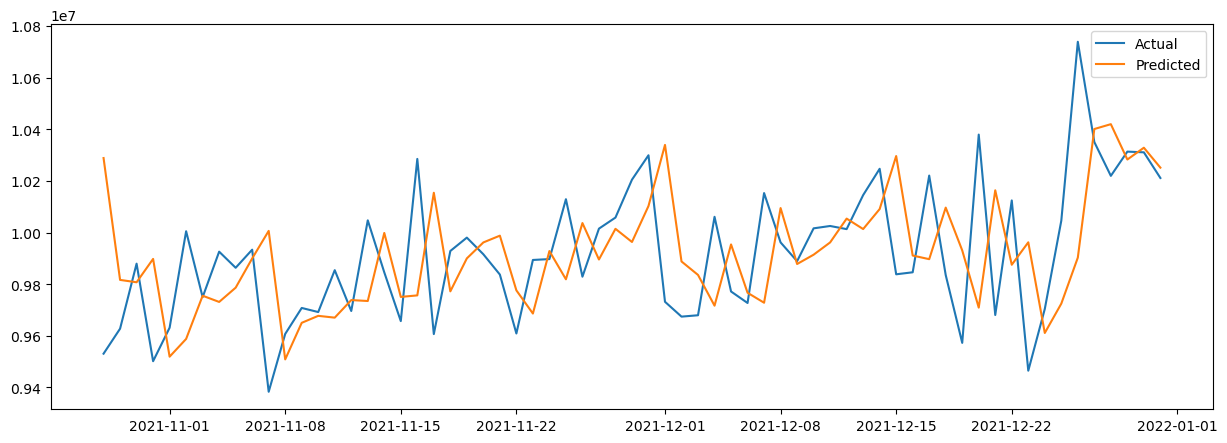

In [42]:
# Check the accuracy of the model
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

print('MAE:', mean_absolute_error(df['Receipt_Count'][-test_length:], final_forecasts))
print('RMSE:', np.sqrt(mean_squared_error(df['Receipt_Count'][-test_length:], final_forecasts)))

# Plot the actual and predicted values
plt.figure(figsize=(15, 5))
plt.plot(df.index[-test_length:], df['Receipt_Count'][-test_length:], label='Actual')
plt.plot(df.index[-test_length:], final_forecasts, label='Predicted')
plt.legend()
plt.show();

# Evaluating LSTM Addition

In [43]:
data = np.array(df['Receipt_Count']).reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

In [44]:
def create_dataset(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i+n_steps])
        y.append(data[i + n_steps])
    return X, y

In [45]:
def expanding_window_lstm(data_scaled, n_steps, test_length, epochs=200):
    forecasts = []
    train = data_scaled[:-test_length].tolist()
    
    for i in range(test_length):
        # Prepare train data for LSTM shape
        X_train, y_train = create_dataset(train, n_steps)  # Define create_dataset function
        
        # Define LSTM model
        model = Sequential()
        model.add(LSTM(50, activation='relu', input_shape=(n_steps, 1)))  # Assuming 1 feature
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        
        # Fit model
        model.fit(np.array(X_train), np.array(y_train), epochs=epochs, verbose=0)
        
        # Forecast the next point
        x_input = np.array(train[-n_steps:]).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        
        # Add the forecast to the list
        forecasts.append(yhat[0,0])
        
        # Add true observation to training data for next iteration
        train.append(data_scaled[len(train)].tolist())
        
    return scaler.inverse_transform(np.array(forecasts).reshape(-1, 1)).flatten()

In [46]:
def stack_forecasts(*forecasts):
    return np.mean(np.column_stack(forecasts), axis=1)

# Generate LSTM forecasts
lstm_forecasts = expanding_window_lstm(data_scaled, n_steps=7, test_length=test_length)

# Stack the forecasts
final_forecasts = stack_forecasts(arima_forecasts, stl_forecasts, lstm_forecasts)

MAE: 204242.60041201516
RMSE: 272857.5858880276


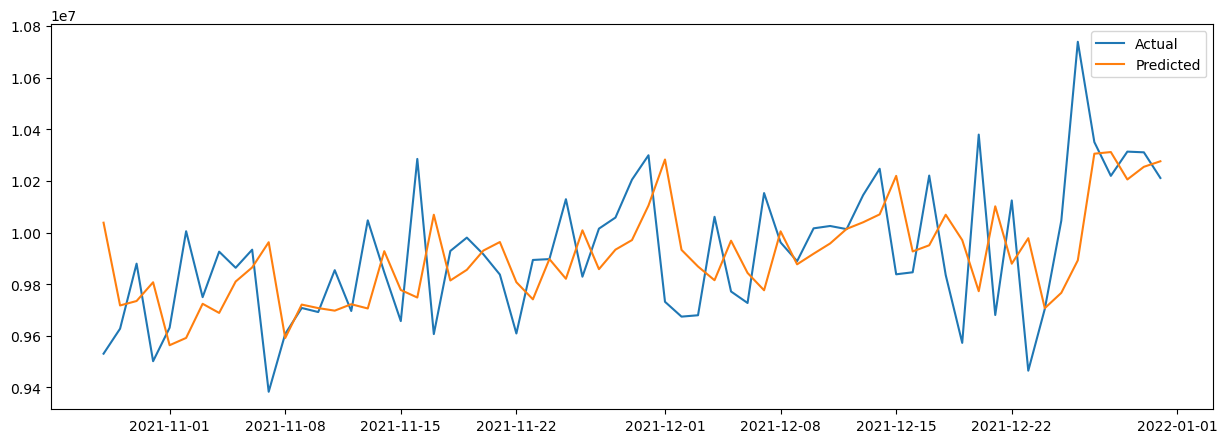

In [48]:
# Check the accuracy of the model

print('MAE:', mean_absolute_error(df['Receipt_Count'][-test_length:], final_forecasts))
print('RMSE:', np.sqrt(mean_squared_error(df['Receipt_Count'][-test_length:], final_forecasts)))

# Plot the actual and predicted values
plt.figure(figsize=(15, 5))
plt.plot(df.index[-test_length:], df['Receipt_Count'][-test_length:], label='Actual')
plt.plot(df.index[-test_length:], final_forecasts, label='Predicted')
plt.legend()
plt.show();